In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
from scipy.sparse import csr_matrix, identity, diags
from ldpc.codes import rep_code
from bposd.hgp import hgp
from ldpc import bposd_decoder
from ldpc.code_util import codewords, compute_code_distance
from ldpc.mod2 import rank
from numba import njit, prange, set_num_threads, int8
from itertools import chain, combinations
import networkx as nx
from networkx.algorithms.bipartite import configuration_model, biadjacency_matrix
from multiprocess import Pool
import cLDPC_BP_decoding
import HGP_BPOSD_decoding
import Toric_MWPM_decoding
from matplotlib import rcParams
rcParams['font.size'] = 14
rcParams['text.usetex'] = True

# Convenient functions

In [2]:
def f(p,a):
    return 1-(1-p)**a

def df(p,a):
    return a*(1-p)**(a-1)

def err(p, N):
    return np.sqrt(p*(1-p)/N)

## Sample random LDPC codes (configuration model)

In [223]:
H_list = []

In [237]:
n = 96*32
d_v = 7
d_c = 8

graph = configuration_model(d_v*np.ones(n,dtype=int), d_c*np.ones(int(n*d_v/d_c),dtype=int), create_using=nx.Graph())
H = biadjacency_matrix(graph, row_order=np.arange(n)).T.toarray()

In [238]:
H_list.append(H)

In [239]:
for H in H_list:
    print(len(H), len(H[0]))

84 96
168 192
336 384
672 768
1344 1536
2688 3072


# Run cLDPC simulation (BP decoding)

In [109]:
res = 50
T_list = np.linspace(0.7, 1.4, res)
eq_time = 100
iters = 5000

THREADS = 10    # Number of parallel threads
cLDPC_LERs = np.zeros([len(H_list),res])
pool = Pool(processes=THREADS)

for i in range(len(H_list)):
    H = H_list[i]
    N = len(H[0])
    init_state = np.zeros(N, dtype=int)
    init_syndrome = np.zeros(len(H), dtype=int)
    for r in range(res):
        print('Code: {} / {} , Res: {} / {}        '.format(i+1,len(H_list),r,res), end='\r')
        params = (H, T_list[r], 10, init_state, init_syndrome, eq_time, iters//THREADS)
        args = [params for j in range(THREADS)]
        if cLDPC_LERs[i,r-1] == 1:    # If all previous runs failed, terminate simulation
            cLDPC_LERs[i,r] = 1
        elif __name__ ==  '__main__':
            failures = pool.starmap(cLDPC_BP_decoding.get_BP_failures, args)
            cLDPC_LERs[i,r] = np.sum(failures) / (iters//THREADS*THREADS)
pool.close()

In [153]:
# np.savetxt('Data/(4,5)-cLDPC_iters={}.txt'.format(iters), cLDPC_LERs)

### Load saved data

In [3]:
cLDPC_LERs = np.loadtxt('Data/(4,5)-cLDPC_iters=5000.txt')
T_list = np.linspace(0.7, 1.4, 50)
N_list = [100,200,400,800,1600]
eq_time = 100
d_v = 4
d_c = 5
iters = 5000

## Plot cLDPC logical error rates

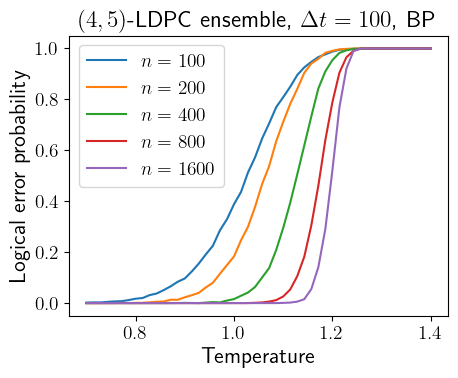

In [5]:
plt.figure(figsize=[4.8,4])
for i in range(len(cLDPC_LERs)):
    plt.plot(T_list, cLDPC_LERs[i], label=r'$n = {}$'.format(N_list[i]))
    plt.fill_between(T_list, cLDPC_LERs[i]-err(cLDPC_LERs[i],iters), cLDPC_LERs[i]+err(cLDPC_LERs[i],iters), alpha=0.2)
plt.title(r'$({},{})$-LDPC ensemble, $\Delta t={}$, BP'.format(d_v,d_c,eq_time))
plt.xlabel(r'Temperature', fontsize=16)
plt.ylabel(r'Logical error probability', fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
# plt.savefig('Plots/4_5_cLDPC_BP.pdf')

# Fix cLDPC and vary equilibration time

In [40]:
n = 1000
d_v = 4
d_c = 5

graph = configuration_model(d_v*np.ones(n,dtype=int), d_c*np.ones(int(n*d_v/d_c),dtype=int), create_using=nx.Graph())
H = biadjacency_matrix(graph, row_order=np.arange(n)).T.toarray()

In [44]:
res = 30
T_list = np.linspace(1.1, 1.25, res)
eq_times = np.array([25,50,75,100])
iters = 5000

THREADS = 20    # Number of parallel threads
cLDPC_LERs = np.zeros([len(eq_times),res])
pool = Pool(processes=THREADS)

for i in range(len(eq_times)):
    N = len(H[0])
    init_state = np.zeros(N, dtype=int)
    init_syndrome = np.zeros(len(H), dtype=int)
    for r in range(res):
        print('Codes: {} / {} , Res: {} / {}        '.format(i+1,len(eq_times),r,res), end='\r')
        params = (H, T_list[r], 10, init_state, init_syndrome, eq_times[i], iters//THREADS)
        args = [params for j in range(THREADS)]
        if cLDPC_LERs[i,r-1] == 1:    # If all previous runs failed, terminate simulation
            cLDPC_LERs[i,r] = 1
        elif __name__ ==  '__main__':
            failures = pool.starmap(cLDPC_BP_decoding.get_BP_failures, args)
            cLDPC_LERs[i,r] = np.sum(failures) / (iters//THREADS*THREADS)
pool.close()

In [45]:
# np.savetxt('Data/(4,5)-cLDPC_dt_n={}_iters={}.txt'.format(N,iters), cLDPC_LERs)

### Load saved data

In [31]:
T_list = np.linspace(1.05, 1.3, 50)
eq_times = np.array([25,50,75,100])
iters=1000

## Plot simulation results (varying $\Delta t$)

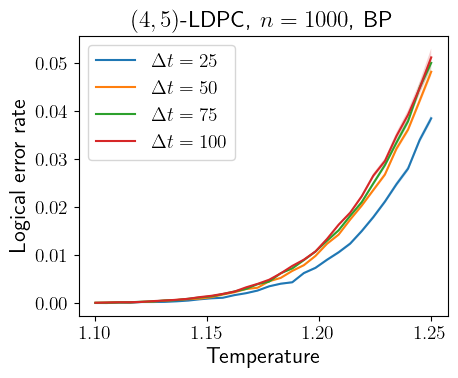

In [49]:
plt.figure(figsize=[4.8,4])
for i in range(len(eq_times)):
    y = f(cLDPC_LERs[i], 1/eq_times[i])
    y_err = df(cLDPC_LERs[i], 1/eq_times[i]) * err(cLDPC_LERs[i],iters)
    plt.plot(T_list, y, label=r'$\Delta t = {}$'.format(eq_times[i]))
    plt.fill_between(T_list, y-y_err, y+y_err, alpha=0.2)
plt.title(r'$({},{})$-LDPC, $n={}$, BP'.format(d_v,d_c,len(H[0])))
plt.xlabel(r'Temperature', fontsize=16)
plt.ylabel(r'Logical error rate', fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()
# plt.savefig('Plots/4_5_cLDPC_dt_BP_normalized.pdf')

## Sample HGP parent codes

In [78]:
parent_list = []

In [90]:
n = 45
d_v = 4
d_c = 5

graph = configuration_model(d_v*np.ones(n,dtype=int), d_c*np.ones(int(n*d_v/d_c),dtype=int), create_using=nx.Graph())
H = biadjacency_matrix(graph, row_order=np.arange(n)).T.toarray()
print(compute_code_distance(H), rank(H))

12 36


In [91]:
parent_list.append(H)

In [92]:
for H in parent_list:
    print(len(H[0]))

20
25
35
45


### Surface code

In [3]:
n_list = [10,15,20,25,30]
parent_list = [rep_code(n) for n in n_list]

### Take hypergraph product to construct CSS code

In [93]:
HGP_list = [hgp(h1=H, h2=H, compute_distance=False) for H in parent_list]

In [94]:
for code in HGP_list:
    print(code.N)
N_list = [code.N for code in HGP_list]

656
1025
2009
3321


# Run HGP simulation (BP+OSD decoding)

In [95]:
res = 30
T_list = np.linspace(0.3, 1, res)
eq_time = 100
iters = 500

THREADS = 20    # Number of parallel threads
HGP_LERs = np.zeros([len(HGP_list),res])
pool = Pool(processes=THREADS)

for i in range(len(HGP_list)):
    code = HGP_list[i]
    m = len(code.hx)
    N = code.N
    init_state = np.zeros(N, dtype=int)
    init_syndrome = np.zeros(m, dtype=int)
    for r in range(res):
        print('Code: {} / {} , Res: {} / {}        '.format(i+1,len(HGP_list),r+1,res), end='\r')
        params = (code, T_list[r], [10,0], init_state, init_syndrome, eq_time, iters//THREADS)
        args = [params for j in range(THREADS)]
        if HGP_LERs[i,r-1] == 1:     # If all previous runs failed, terminate simulation
            HGP_LERs[i,r] = 1
        elif __name__ ==  '__main__':
            failures = pool.starmap(HGP_BPOSD_decoding.get_BPOSD_failures, args)
            # failures = pool.starmap(Toric_MWPM_decoding.get_MWPM_failures, args)
            HGP_LERs[i,r] = np.sum(failures) / (iters//THREADS*THREADS)
pool.close()

In [98]:
# np.savetxt('Data/(4,5)-HGP_iters={}_n=25_30_35_40.txt'.format(iters), HGP_LERs)
# np.savetxt('Data/surface_iters={}.txt'.format(iters), HGP_LERs)
HGP_LERs = np.loadtxt('Data/(4,5)-HGP_iters=500_n=25_30_35_40.txt')

### Load saved data

In [31]:
eq_time = 100
T_list = np.linspace(0.6, 1.6, 30)
iters = 300
d_v = 7
d_c = 8
HGP_LERs = np.zeros([4,30])
data1 = np.loadtxt('Data/(7,8)-HGP_iters=900_n=16.txt')
data2 = np.loadtxt('Data/(7,8)-HGP_iters=900_n=16_24.txt')
data3 = np.loadtxt('Data/(7,8)-HGP_iters=300_n=24_32_40_48.txt')
HGP_LERs[0] = data1
HGP_LERs[1] = data2[1]
HGP_LERs[2] = data3[2]
HGP_LERs[3] = data3[3]

In [100]:
N_list = [25**2+20**2, 30**2+24**2, 35**2+28**2, 40**2+32**2]

## Plot HGP logical error rates

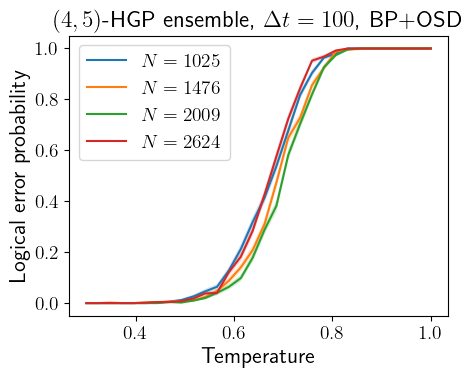

In [101]:
plt.figure(figsize=[4.8,4])
for i in range(len(N_list)):
    plt.plot(T_list, HGP_LERs[i], label=r'$N = {}$'.format(N_list[i]))
    plt.fill_between(T_list, HGP_LERs[i]-err(HGP_LERs[i],iters), HGP_LERs[i]+err(HGP_LERs[i],iters), alpha=0.2)
plt.title(r'$({},{})$-HGP ensemble, $\Delta t={}$, BP+OSD'.format(d_v,d_c,eq_time))
# plt.title(r'2D Surface, $\Delta t={}$, MWPM'.format(eq_time))
plt.xlabel(r'Temperature', fontsize=16)
plt.ylabel(r'Logical error probability', fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
# plt.savefig('Plots/4_5_HGP_BPOSD.pdf')
# plt.savefig('Plots/surface_MWPM.pdf')

# Fix HGP code and vary equilibration time

In [56]:
n = 32
d_v = 7
d_c = 8

graph = configuration_model(d_v*np.ones(n,dtype=int), d_c*np.ones(int(n*d_v/d_c),dtype=int), create_using=nx.Graph())
H = biadjacency_matrix(graph, row_order=np.arange(n)).T.toarray()
print(compute_code_distance(H), rank(H))

13 28


In [57]:
HGPcode = hgp(h1=H, h2=H, compute_distance=False)

### Surface code

In [54]:
HGPcode = hgp(h1=rep_code(25), h2=rep_code(25), compute_distance=False)

## Run simulation

In [55]:
res = 30
T_list = np.linspace(0.15, 0.3, res)
eq_times = np.array([25,50,75,100])
iters = 10000

THREADS = 20    # Number of parallel threads
HGP_LERs = np.zeros([len(eq_times),res])
pool = Pool(processes=THREADS)

for i in range(len(eq_times)):
    code = HGPcode
    m = len(code.hx)
    N = code.N
    init_state = np.zeros(N, dtype=int)
    init_syndrome = np.zeros(m, dtype=int)
    for r in range(res):
        print('Code: {} / {} , Res: {} / {}        '.format(i+1,len(eq_times),r,res), end='\r')
        params = (code, T_list[r], [10,0], init_state, init_syndrome, eq_times[i], iters//THREADS)
        args = [params for j in range(THREADS)]
        if HGP_LERs[i,r-1] == 1:     # If all previous runs failed, terminate simulation
            HGP_LERs[i,r] = 1
        elif __name__ ==  '__main__':
            # failures = pool.starmap(HGP_BPOSD_decoding.get_BPOSD_failures, args)
            failures = pool.starmap(Toric_MWPM_decoding.get_MWPM_failures, args)
            HGP_LERs[i,r] = np.sum(failures) / (iters//THREADS*THREADS)
pool.close()

In [56]:
# np.savetxt('Data/(7,8)-HGP_dt_n=32_iters={}.txt'.format(iters), HGP_LERs)
# np.savetxt('Data/surface_dt_n=25_iters={}.txt'.format(iters), HGP_LERs)

### Load saved data

In [25]:
d_v = 7
d_c = 8
T_list = np.linspace(1, 1.3, 30)
eq_times = np.array([25,50,75,100])
iters = 5000
HGP_LERs = np.loadtxt('Data/(7,8)-HGP_dt_n=32_iters=5000.txt')

## Plot simulation results (varying $\Delta t$)

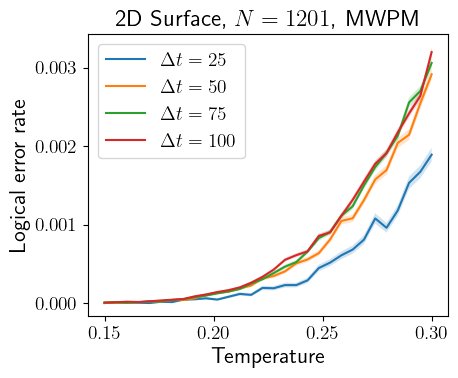

In [59]:
plt.figure(figsize=[4.8,4])
for i in range(len(eq_times)):
    y = f(HGP_LERs[i], 1/eq_times[i])
    y_err = df(HGP_LERs[i], 1/eq_times[i]) * err(HGP_LERs[i],iters)
    plt.plot(T_list, y, label=r'$\Delta t = {}$'.format(eq_times[i]))
    plt.fill_between(T_list, y-y_err, y+y_err, alpha=0.2)
# plt.title(r'$({},{})$-HGP, $N={}$, BP+OSD'.format(d_v,d_c,HGPcode.N))
plt.title(r'2D Surface, $N={}$, MWPM'.format(HGPcode.N))
plt.xlabel(r'Temperature', fontsize=16)
plt.ylabel(r'Logical error rate', fontsize=16)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()
# plt.savefig('Plots/7_8_HGP_dt_BPOSD_normalized.pdf')
# plt.savefig('Plots/surface_dt_MWPM_normalized.pdf')